In [1]:
import numpy as np
import scipy
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
import time
from os import path


In [2]:
import itertools
from operator import add
from quimb import *
import quimb

r=2 # local Hilbert space dim

def ising_chain(L, g=1.0, h=0.0, cyclic=True,
                sparse=True):

# g=0
# h=0
# cyclic=True
# m= 4
    dims = [r] * L  # shape (n, m)

    # generate tuple of all site coordinates
    # sites = tuple(itertools.product(range(n)))
    sites= tuple(range(L))
    # print(sites)

    # generate neighbouring pairs of coordinates
    def gen_pairs():
        for i in sites:
    #         print(i)
            right = (i + 1) % L 
            # ignore wraparound coordinates if not cyclic
            if cyclic or right != 0:
                yield (i, right)

    # generate all pairs of coordinates and directions
    pairs_ss = tuple(gen_pairs())
    # pairs_ss = tuple(itertools.product(gen_pairs(), 'xyz'))
    print(pairs_ss)
#     print(sites)

    # make XX, YY and ZZ interaction from pair_s
    #     e.g. arg ([(3, 4), (3, 5)], 'z')
    def interactions(pair):
        Sz = spin_operator('z', sparse=True)
        return -ikron([2*Sz, 2*Sz], dims, inds=pair)

    # function to make Z field at ``site``
    def fields(site):
        Sx = spin_operator('x', sparse=True)
        Sz = spin_operator('z', sparse=True)
        return -ikron(g * 2*Sx+ h * 2*Sz, dims, inds=[site])

    # combine all terms
    all_terms = itertools.chain(map(interactions, pairs_ss),
                                map(fields, sites))
    H = sum(all_terms)

    # can improve speed of e.g. eigensolving if known to be real
    if isreal(H):
        H = H.real

    if not sparse:
        H = qarray(H.A)
    else:
        H= quimb.core.sparse_matrix(H)

    return H


# negativity spectrum

In [34]:
La = 2
Lb = 2
Lab = La + Lb
Lc = 6
Nrep = 1000

r = 2
Nab = r**Lab
Nc = r**Lc
dims = [r] * Lab

# chaotic
# H1ref = ising_chain(L=Lab, g=1.05, h=-0.5, cyclic=False,sparse=False)
# ebH = scipy.linalg.expm(-beta*H1ref/2)
# v1ref=np.zeros(Nrep*Nab)
# %time es= np.linalg.eigvalsh(H1)
H1 = ising_chain(L=Lab, g=1.05, h=-0.5, cyclic=False,sparse=True)
# ge0 , _ = scipy.sparse.linalg.eigsh(H1,1)
# ge0 = groundenergy(H1)

ge0={"4":6.16103425,"6":9.60646994,"8":13.0528867, "10":16.499332, "12":19.94577803, "14":23.392224094, "16":26.83867014, "18":30.28511620}
# print(es[0],es[-1],ge0)
v1b=np.zeros(Nrep*Nab)

# # H2 = ising_chain(L=Lc, g=1.05, h=-0.5, cyclic=False,sparse=True)
# # v2b=np.zeros(Nrep*Nab)

beta = 1/(4*np.abs(ge0["%d" % (Lab)])/Lab)
Nbeta = 4

for i_r in range(Nrep):
    #### no symmetry
    X=np.random.randn(Nab,Nc)+1j*np.random.randn(Nab,Nc)
    
#     Xref= np.dot(ebH,X)
#     mat= dot(Xref,np.matrix(Xref).H)
#     rho= mat / np.trace(mat)
#     rT = partial_transpose(rho, dims=dims, sysa=np.arange(La))
#     l1T=np.linalg.eigvalsh(rT)
#     v1ref[i_r*Nab:(i_r+1)*Nab] = l1T #*(Nab)
    
    if beta >0:
        for i_b in range(Nbeta):
            X -= (beta/Nbeta/2)*dot(H1,X)
    mat= dot(X,np.matrix(X).H)
    rho= mat / np.trace(mat)
    rT = partial_transpose(rho, dims=dims, sysa=np.arange(La))
    l1T=np.linalg.eigvalsh(rT)
    v1b[i_r*Nab:(i_r+1)*Nab] = l1T*(Nab)

#     if beta >0:
#         for i_b in range(Nbeta):
#             X -= (beta/Nbeta/2)*dot(X,H2)
#     mat= dot(X,np.matrix(X).H)
#     rho= mat / np.trace(mat)
#     rT = partial_transpose(rho, dims=dims, sysa=np.arange(La))
#     l1T=np.linalg.eigvalsh(rT)
#     v2b[i_r*Nab:(i_r+1)*Nab] = l1T #*(Nab)



((0, 1), (1, 2), (2, 3))


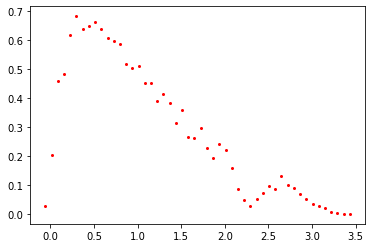

In [35]:

num_bins=50

n, bin_edges = np.histogram(v1b, bins=num_bins)
bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])

plt.figure()
plt.plot(bins_center,n,'o',color='red',markersize=2)#,color='C%d' % (i_n),label='Na=%d' % (i_n+1) )
# plt.xlim([-0.01,0.03])
# plt.ylim([0,20])

# n, bin_edges = np.histogram(v2b, bins=num_bins)
# bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
# n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])
# plt.plot(bins_center,n,'o',color='blue',markersize=2)#,color='C%d' % (i_n),label='Na=%d' % (i_n+1) )

plt.show()


# resolvent function

In [41]:
from quimb.linalg.approx_spectral import *

La = 2
Lb = 2
Lab = La + Lb
Lc = 6
Nrep = 10

r = 2
Nab = r**Lab
Nc = r**Lc
dims = [r] * Lab

λlist = np.linspace(-0.5,4,40)
ϵ = 0.1/Nab

ge0={"4":6.16103425,"6":9.60646994,"8":13.0528867, "10":16.499332, "12":19.94577803, "14":23.392224094, "16":26.83867014, "18":30.28511620}
beta0=1/4
beta = beta0/(ge0["%d" % (Lab)]/Lab)
Nbeta = 6

if beta>0:
    H1 = ising_chain(L=Lab, g=1.05, h=-0.5, cyclic=False,sparse=True)

# G = np.zeros((len(λlist),Nrep))
G0 = np.zeros((len(λlist),Nrep))
   
for i_r in range(Nrep):
#     if i_r%10 ==0:
    print("(Labc, r): ", La, Lb, Lc, i_r)
    #### no symmetry

    X=np.random.randn(Nab,Nc)+1j*np.random.randn(Nab,Nc)

    if beta >0:
        for i_b in range(Nbeta):
            X -= (beta/Nbeta/2)*dot(H1,X)

    t_timer=time.time()
    psi = normalize(np.reshape(X,[Nab*Nc,1]))

#     rho = lazy_ptr_linop(psi, dims=[r]*(Lab+Lc), sysa=np.arange(Lab))

#     mat = np.dot(X,np.matrix(X).H)
#     rho_o = mat/np.trace(mat)
#     rT_o = partial_transpose(rho_o, dims=[r]*Lab, sysa=np.arange(La))

    rT = lazy_ptr_ppt_linop(psi, dims=[r]*(Lab+Lc), sysa=np.arange(La), sysb=np.arange(La,Lab))
    for i_l in range(len(λlist)):
        print(i_l)
        λ = λlist[i_l]/Nab
#         G[i_l,i_r] = approx_spectral_function(rT, lambda x: np.imag(1/(λ-x+1j*ϵ)))
        G0[i_l,i_r] = np.imag(np.trace(np.linalg.inv((λ+1j*ϵ)*eye(Nab)-rT_o)))

((0, 1), (1, 2), (2, 3))
(Labc, r):  2 2 6 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
(Labc, r):  2 2 6 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
(Labc, r):  2 2 6 2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
(Labc, r):  2 2 6 3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
(Labc, r):  2 2 6 4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
(Labc, r):  2 2 6 5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
(Labc, r):  2 2 6 6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
(Labc, r):  2 2 6 7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
1

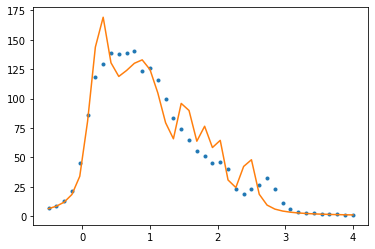

In [42]:
plt.plot(λlist,-np.mean(G,axis=1)/pi,".")
plt.plot(λlist,-np.mean(G0,axis=1)/pi,"-")
# plt.ylim([0,100])